In [429]:
import os
import gzip
import missingno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold,RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import statsmodels.api as sm
from xgboost import XGBRegressor
from scipy.stats import randint as sp_randint

sns.set(style="whitegrid")

In [430]:
# folder_path = r'C:\Users\debop\Documents\Healthcare Project\MIMIC Dataset'
# dataframes = {}

# for filename in os.listdir(folder_path):
#     if filename.endswith('.gz'):
#         name = os.path.splitext(filename)[0]
#         with gzip.open(os.path.join(folder_path, filename), 'rb') as f:
#             df = pd.read_csv(f)
#             dataframes[name] = df

# print(dataframes.keys()) 

In [431]:
gzipped_file_path = r"C:\Users\debop\Documents\Healthcare Project\MIMIC Dataset\PATIENTS.csv.gz"
csv_filename = "PATIENTS.csv"

with gzip.open(gzipped_file_path, 'rb') as f:
    # Read the CSV file inside the gzip file using pandas
    df_patients = pd.read_csv(f,usecols=[0,1,2,3])
df_patients.head(5)    

,ROW_ID,SUBJECT_ID,GENDER,DOB
0,234,249,F,2075-03-13 00:00:00
1,235,250,F,2164-12-27 00:00:00
2,236,251,M,2090-03-15 00:00:00
3,237,252,M,2078-03-06 00:00:00
4,238,253,F,2089-11-26 00:00:00


In [432]:
np.unique(df_patients['SUBJECT_ID'].unique)

array([<bound method Series.unique of 0          249
       1          250
       2          251
       3          252
       4          253
                ...
       46515    44089
       46516    44115
       46517    44123
       46518    44126
       46519    44128
       Name: SUBJECT_ID, Length: 46520, dtype: int64>], dtype=object)

In [433]:
print('Total Number of patients:' , df_patients['SUBJECT_ID'].nunique())

Total Number of patients: 46520


In [434]:
df_patients['GENDER'].value_counts()

GENDER
M    26121
F    20399
Name: count, dtype: int64

In [435]:
#Convert DOB to Datetime
df_patients['DOB'] = pd.to_datetime(df_patients['DOB'])

In [436]:
df_patients = df_patients[['SUBJECT_ID', 'GENDER','DOB',]]
df_patients.head()

,SUBJECT_ID,GENDER,DOB
0,249,F,2075-03-13
1,250,F,2164-12-27
2,251,M,2090-03-15
3,252,M,2078-03-06
4,253,F,2089-11-26


In [437]:
gzipped_file_path = r"C:\Users\debop\Documents\Healthcare Project\MIMIC Dataset\ADMISSIONS.csv.gz"
csv_filename = "ADMISSIONS.csv"

with gzip.open(gzipped_file_path, 'rb') as f:
    # Read the CSV file inside the gzip file using pandas
    df_admissions = pd.read_csv(f)
df_admissions.head(5)  

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


<Axes: >

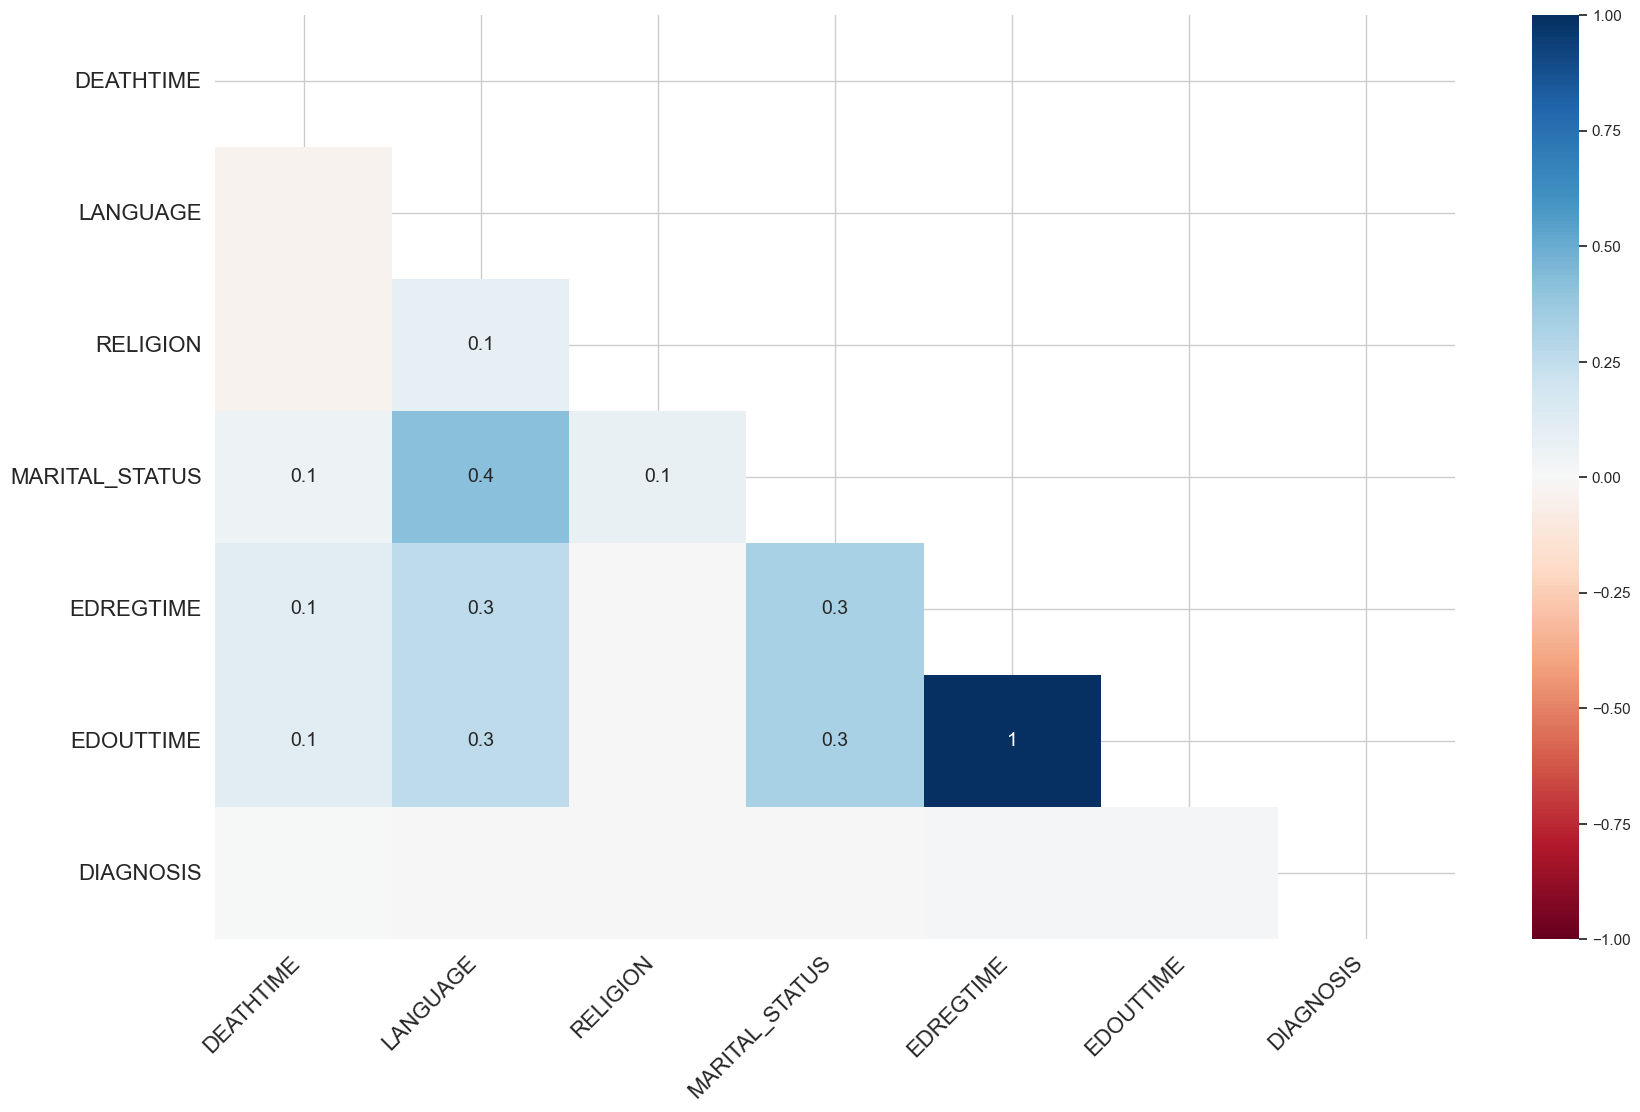

In [438]:
missingno.heatmap(df_admissions)

In [439]:
# missingno.bar(df_admissions)

In [440]:
df_admissions.isnull().sum()

ROW_ID                      0
SUBJECT_ID                  0
HADM_ID                     0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               53122
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
LANGUAGE                25332
RELIGION                  458
MARITAL_STATUS          10128
ETHNICITY                   0
EDREGTIME               28099
EDOUTTIME               28099
DIAGNOSIS                  25
HOSPITAL_EXPIRE_FLAG        0
HAS_CHARTEVENTS_DATA        0
dtype: int64

In [441]:
df_admissions['ADMITTIME'] = pd.to_datetime(df_admissions['ADMITTIME'])
df_admissions['DISCHTIME'] = pd.to_datetime(df_admissions['DISCHTIME'])
df_admissions['LOS'] = (df_admissions['DISCHTIME'] - df_admissions['ADMITTIME']).dt.total_seconds()/86400

In [442]:
df_admissions['HADM_ID'].nunique()

58976

In [443]:
df_admissions.describe().round(0)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS
count,58976.0,58976.0,58976.0,58976,58976,58976.0,58976.0,58976.0
mean,29488.0,33756.0,149971.0,2151-03-22 15:38:36.768515072,2151-04-01 18:51:27.117810688,0.0,1.0,10.0
min,1.0,2.0,100001.0,2100-06-07 19:59:00,2100-06-09 17:09:00,0.0,0.0,-1.0
25%,14745.0,11994.0,124953.0,2126-02-22 08:30:00,2126-03-04 11:33:30,0.0,1.0,4.0
50%,29488.0,24134.0,149990.0,2151-01-15 09:39:00,2151-01-29 16:49:30,0.0,1.0,6.0
75%,44232.0,53852.0,174966.0,2176-07-09 02:32:00,2176-07-19 13:30:00,0.0,1.0,12.0
max,58976.0,99999.0,199999.0,2210-08-17 17:13:00,2210-08-24 19:43:00,1.0,1.0,295.0
std,17025.0,28093.0,28883.0,NaN,NaN,0.0,0.0,12.0


In [444]:
df_admissions = df_admissions[df_admissions['LOS']>0]

In [445]:
df_admissions.describe().round(0)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS
count,58878.0,58878.0,58878.0,58878,58878,58878.0,58878.0,58878.0
mean,29493.0,33762.0,149966.0,2151-03-20 12:15:10.600223744,2151-03-30 15:53:00.015286272,0.0,1.0,10.0
min,1.0,2.0,100001.0,2100-06-07 19:59:00,2100-06-09 17:09:00,0.0,0.0,0.0
25%,14750.0,11999.0,124943.0,2126-02-13 07:54:15.000000512,2126-02-24 13:04:15.000000512,0.0,1.0,4.0
50%,29498.0,24141.0,149987.0,2151-01-13 02:07:30,2151-01-26 13:02:30,0.0,1.0,6.0
75%,44238.0,53863.0,174958.0,2176-07-08 19:33:44.999999488,2176-07-17 08:58:00,0.0,1.0,12.0
max,58976.0,99999.0,199999.0,2210-08-17 17:13:00,2210-08-24 19:43:00,1.0,1.0,295.0
std,17025.0,28093.0,28883.0,NaN,NaN,0.0,0.0,12.0


In [446]:
print(f"{df_admissions['HOSPITAL_EXPIRE_FLAG'].sum()} of {df_admissions['SUBJECT_ID'].nunique()} patients died in the hospital.")

5774 of 46445 patients died in the hospital.


In [447]:
df_admissions['ETHNICITY'].value_counts(dropna=False)

ETHNICITY
WHITE                                                       40939
BLACK/AFRICAN AMERICAN                                       5434
UNKNOWN/NOT SPECIFIED                                        4502
HISPANIC OR LATINO                                           1693
ASIAN                                                        1508
OTHER                                                        1507
UNABLE TO OBTAIN                                              809
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                                           85


In [448]:
# Define the replacement mapping
ethnicity_mapping = {
    r'^ASIAN\D*': 'ASIAN',
    r'^WHITE\D*': 'WHITE',
    r'^HISPANIC\D*': 'HISPANIC/LATINO',
    r'^BLACK\D*': 'BLACK/AFRICAN AMERICAN',
    'UNABLE TO OBTAIN': 'OTHER/UNKNOWN',
    'OTHER': 'OTHER/UNKNOWN',
    'PATIENT DECLINED TO ANSWER': 'OTHER/UNKNOWN',
    'UNKNOWN/NOT SPECIFIED': 'OTHER/UNKNOWN'
}

# Apply the replacements using regex
df_admissions['ETHNICITY'] = df_admissions['ETHNICITY'].replace(ethnicity_mapping, regex=True)

# Identify the top 5 most frequent ethnicities
top_ethnicities = df_admissions['ETHNICITY'].value_counts().nlargest(5).index.tolist()

# Replace less frequent ethnicities with 'OTHER/UNKNOWN'
df_admissions.loc[~df_admissions['ETHNICITY'].isin(top_ethnicities), 'ETHNICITY'] = 'OTHER/UNKNOWN'
df_admissions['ETHNICITY'].value_counts()

ETHNICITY
WHITE                     41268
OTHER/UNKNOWN              7700
BLACK/AFRICAN AMERICAN     5779
HISPANIC/LATINO            2125
ASIAN                      2006
Name: count, dtype: int64

In [449]:
df_admissions['INSURANCE'].value_counts(dropna=False)

INSURANCE
Medicare      28174
Private       22542
Medicaid       5778
Government     1781
Self Pay        603
Name: count, dtype: int64

In [450]:
df_admissions['RELIGION'].value_counts(dropna=False)

RELIGION
CATHOLIC                  20580
NOT SPECIFIED             11738
UNOBTAINABLE               8242
PROTESTANT QUAKER          7121
JEWISH                     5307
OTHER                      2695
EPISCOPALIAN                771
GREEK ORTHODOX              459
NaN                         452
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: count, dtype: int64

In [451]:
df_admissions['RELIGION'] = df_admissions['RELIGION'].fillna('NOT SPECIFIED')
df_admissions['RELIGION'].value_counts(dropna=False)

RELIGION
CATHOLIC                  20580
NOT SPECIFIED             12190
UNOBTAINABLE               8242
PROTESTANT QUAKER          7121
JEWISH                     5307
OTHER                      2695
EPISCOPALIAN                771
GREEK ORTHODOX              459
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: count, dtype: int64

In [452]:
df_admissions['MARITAL_STATUS'].value_counts(dropna=False)
df_admissions['MARITAL_STATUS'] = df_admissions['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
df_admissions['MARITAL_STATUS'].value_counts(dropna=False)

MARITAL_STATUS
MARRIED              24199
SINGLE               13238
UNKNOWN (DEFAULT)    10440
WIDOWED               7204
DIVORCED              3211
SEPARATED              571
LIFE PARTNER            15
Name: count, dtype: int64

### ICU Stays Processing

In [453]:
#Reading the ICU stay dataset
gzipped_file_path = r"C:\Users\debop\Documents\Healthcare Project\MIMIC Dataset\ICUSTAYS.csv.gz"
csv_filename = "ICUSTAYS.csv"

with gzip.open(gzipped_file_path, 'rb') as f:
    # Read the CSV file inside the gzip file using pandas
    df_icuStays = pd.read_csv(f)
df_icuStays.head(5)    

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [454]:
df_icuStays.shape

(61532, 12)

In [455]:
#Unique Admission ID
print('Unique Admission ID in ICU',df_icuStays['HADM_ID'].nunique())
print('Unique Stays ID in ICU',df_icuStays['ICUSTAY_ID'].nunique())
print('Unique Patients in ICU',df_icuStays['SUBJECT_ID'].nunique())

Unique Admission ID in ICU 57786
Unique Stays ID in ICU 61532
Unique Patients in ICU 46476


In [456]:
print('Repeated ICU patients',df_icuStays['SUBJECT_ID'].duplicated().sum())
print('Repeated ICU patients for same Admission ID',df_icuStays['HADM_ID'].duplicated().sum())

Repeated ICU patients 15056
Repeated ICU patients for same Admission ID 3746


In [457]:
df_icuStays_sum = df_icuStays.groupby(['HADM_ID'])['LOS'].sum().reset_index()

In [458]:
df_icuStays_sum.describe().round(0)

,HADM_ID,LOS
count,57786.0,57786.0
mean,149973.0,5.0
std,28883.0,10.0
min,100001.0,0.0
25%,124968.0,1.0
50%,149968.0,2.0
75%,174986.0,5.0
max,199999.0,261.0


#### Plotting the LOS Histogram

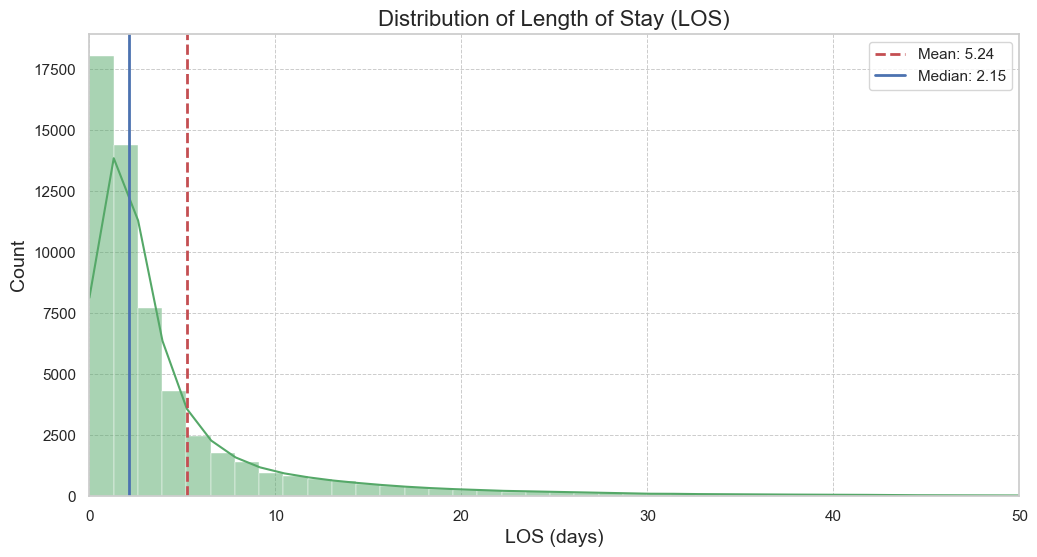

In [459]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(df_icuStays_sum['LOS'], bins=200, color='#55a868', kde=True)

plt.xlim(0, 50)

mean_los = df_icuStays_sum['LOS'].mean()
median_los = df_icuStays_sum['LOS'].median()
plt.axvline(mean_los, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_los:.2f}')
plt.axvline(median_los, color='b', linestyle='-', linewidth=2, label=f'Median: {median_los:.2f}')

plt.title('Distribution of Length of Stay (LOS)', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('LOS (days)', fontsize=14)

plt.tick_params(top=False, right=False)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

plt.legend()

plt.show()

In [460]:
df_icuStays_sum.shape, df_admissions.shape

((57786, 2), (58878, 20))

In [461]:
#Reading the Diagnoses dataset
gzipped_file_path = r"C:\Users\debop\Documents\Healthcare Project\MIMIC Dataset\DIAGNOSES_ICD.csv.gz"
csv_filename = "DIAGNOSES_ICD.csv"

with gzip.open(gzipped_file_path, 'rb') as f:
    # Read the CSV file inside the gzip file using pandas
    df_diagnoses = pd.read_csv(f)
df_diagnoses = df_diagnoses[['HADM_ID','ICD9_CODE']]
df_diagnoses.head(5)

,HADM_ID,ICD9_CODE
0,172335,40301
1,172335,486
2,172335,58281
3,172335,5855
4,172335,4254


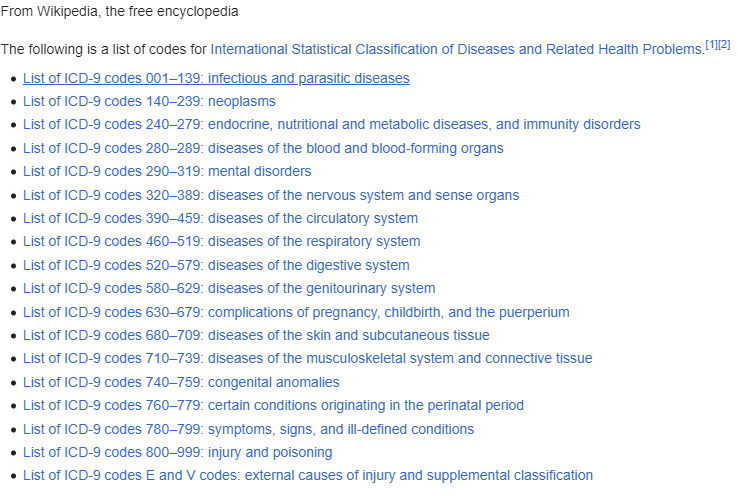
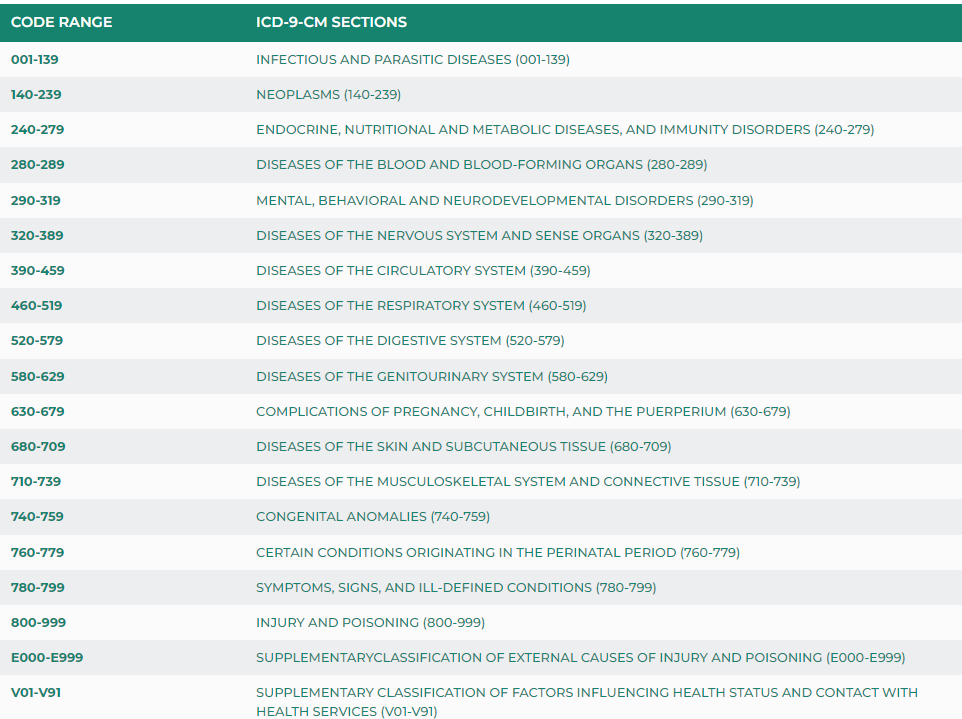

In [462]:
df_diagnoses['code'] = df_diagnoses['ICD9_CODE']
df_diagnoses['code'] = df_diagnoses['code'][~df_diagnoses['code'].str.contains("[a-zA-Z]", na=False)]
df_diagnoses['code'] = df_diagnoses['code'].fillna('999')
df_diagnoses['code'] = df_diagnoses['code'].str.slice(start=0, stop=3, step=1)
df_diagnoses['code'] = df_diagnoses['code'].astype(int)

In [463]:
df_diagnoses['code'].describe()

count    651047.000000
mean        557.703843
std         274.028770
min           3.000000
25%         344.000000
50%         486.000000
75%         782.000000
max         999.000000
Name: code, dtype: float64

In [464]:
df_diagnoses[df_diagnoses['code'] > 700]

,HADM_ID,ICD9_CODE,code
6,172335,7100,710
8,172335,7243,724
17,173633,7100,710
25,173633,78900,789
26,173633,79092,790
...,...,...,...
651030,189314,7820,782
651039,168949,V5861,999
651041,188195,7842,784
651043,188195,V5869,999


In [465]:
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000)]

mapping_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury'}

In [466]:
for i, (lower, upper) in enumerate(icd9_ranges):
    df_diagnoses['code'] = np.where(df_diagnoses['code'].between(lower, upper), i, df_diagnoses['code'])   

df_diagnoses['category'] = df_diagnoses['code'].map(mapping_dict)    
df_diagnoses.head(5)

,HADM_ID,ICD9_CODE,code,category
0,172335,40301,6,circulatory
1,172335,486,7,respiratory
2,172335,58281,9,genitourinary
3,172335,5855,9,genitourinary
4,172335,4254,6,circulatory


In [467]:
df_diagnoses_pivot = df_diagnoses.groupby('HADM_ID')['category'].apply(list).reset_index()
df_diagnoses_pivot.head(5)

,HADM_ID,category
0,100001,"[endocrine, nervous, genitourinary, digestive,..."
1,100003,"[digestive, blood, infectious, digestive, circ..."
2,100006,"[respiratory, respiratory, respiratory, neopla..."
3,100007,"[digestive, digestive, injury, respiratory, ci..."
4,100009,"[circulatory, injury, circulatory, endocrine, ..."


In [468]:
df_diagnoses_pivot['count_diagnoses'] = df_diagnoses_pivot['category'].apply(len)
df_diagnoses_pivot.head(5)

,HADM_ID,category,count_diagnoses
0,100001,"[endocrine, nervous, genitourinary, digestive,...",16
1,100003,"[digestive, blood, infectious, digestive, circ...",9
2,100006,"[respiratory, respiratory, respiratory, neopla...",9
3,100007,"[digestive, digestive, injury, respiratory, ci...",5
4,100009,"[circulatory, injury, circulatory, endocrine, ...",18


In [469]:
exploded = df_diagnoses_pivot['category'].explode()
dummies = pd.get_dummies(exploded)
hadm_item = dummies.groupby(level=0).sum()
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0


In [470]:
hadm_item = hadm_item.join(df_diagnoses_pivot[['HADM_ID','count_diagnoses']], how="outer")
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,HADM_ID,count_diagnoses
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1,100001,16
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,100003,9
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0,100006,9
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0,100007,5
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0,100009,18


In [471]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Apply StandardScaler to the integer column
hadm_item['count_diagnoses'] = scaler.fit_transform(hadm_item[['count_diagnoses']])

### Merge Diagnosis with Admission

In [472]:
df = df_admissions.merge(hadm_item, how='inner', on='HADM_ID')
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,count_diagnoses
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,1,0,0,0,1,0,0,0,0,-0.624669
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,0,0,0,0,1,0,0,0,0,-0.470016
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,0,0,0,1,1,0,1,0,0,-0.160712
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,0,0,0,0,0,0,0,0,0,-1.088625
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,0,0,0,0,0,0,0,0,0,-1.088625


### Merging patients with the above dataframe

In [473]:
df = df.merge(df_patients, how='inner', on='SUBJECT_ID')
df.head(6)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,count_diagnoses,GENDER,DOB
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,0,0,1,0,0,0,0,-0.624669,F,2131-05-07
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,0,0,1,0,0,0,0,-0.470016,M,2082-07-17
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,0,1,1,0,1,0,0,-0.160712,M,2082-07-17
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,0,0,0,0,0,0,0,-1.088625,M,2100-05-31
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,0,0,0,0,0,0,0,-1.088625,M,2101-11-21
5,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,...,0,0,0,0,0,0,0,-0.315364,M,2054-05-04


In [474]:
df[df['SUBJECT_ID'] == 23]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,count_diagnoses,GENDER,DOB
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,0,0,1,0,0,0,0,-0.470016,M,2082-07-17
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,0,1,1,0,1,0,0,-0.160712,M,2082-07-17


In [475]:
df_age_min = df[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_age_min.columns = ['SUBJECT_ID', 'ADMITTIME_MIN']
df_age_min.head()

,SUBJECT_ID,ADMITTIME_MIN
0,2,2138-07-17 19:04:00
1,3,2101-10-20 19:08:00
2,4,2191-03-16 00:28:00
3,5,2103-02-02 04:31:00
4,6,2175-05-30 07:15:00


In [476]:
df = df.merge(df_age_min, how='outer', on='SUBJECT_ID')

In [477]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,count_diagnoses,GENDER,DOB,ADMITTIME_MIN
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,0,0,0,0,0,0,-1.243277,M,2138-07-17,2138-07-17 19:04:00
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,0,0,0,0,0,1,-0.315364,M,2025-04-11,2101-10-20 19:08:00
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,...,0,0,0,0,0,0,-0.315364,F,2143-05-12,2191-03-16 00:28:00
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,0,0,0,0,0,0,-1.243277,M,2103-02-02,2103-02-02 04:31:00
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,0,0,0,0,0,0,-0.470016,F,2109-06-21,2175-05-30 07:15:00


In [478]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58878 entries, 0 to 58877
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ROW_ID                58878 non-null  int64         
 1   SUBJECT_ID            58878 non-null  int64         
 2   HADM_ID               58878 non-null  int64         
 3   ADMITTIME             58878 non-null  datetime64[ns]
 4   DISCHTIME             58878 non-null  datetime64[ns]
 5   DEATHTIME             5774 non-null   object        
 6   ADMISSION_TYPE        58878 non-null  object        
 7   ADMISSION_LOCATION    58878 non-null  object        
 8   DISCHARGE_LOCATION    58878 non-null  object        
 9   INSURANCE             58878 non-null  object        
 10  LANGUAGE              33606 non-null  object        
 11  RELIGION              58878 non-null  object        
 12  MARITAL_STATUS        58878 non-null  object        
 13  ETHNICITY       

In [479]:
df['DOB_YEAR'] = df['DOB'].dt.year
df['ADMITTIME_MIN_YEAR'] = df['ADMITTIME_MIN'].dt.year

In [480]:
df['age'] = (df['ADMITTIME_MIN_YEAR'] - df['DOB_YEAR'])
df['age'] = np.where(df['age'] > 90, 90, df['age'])

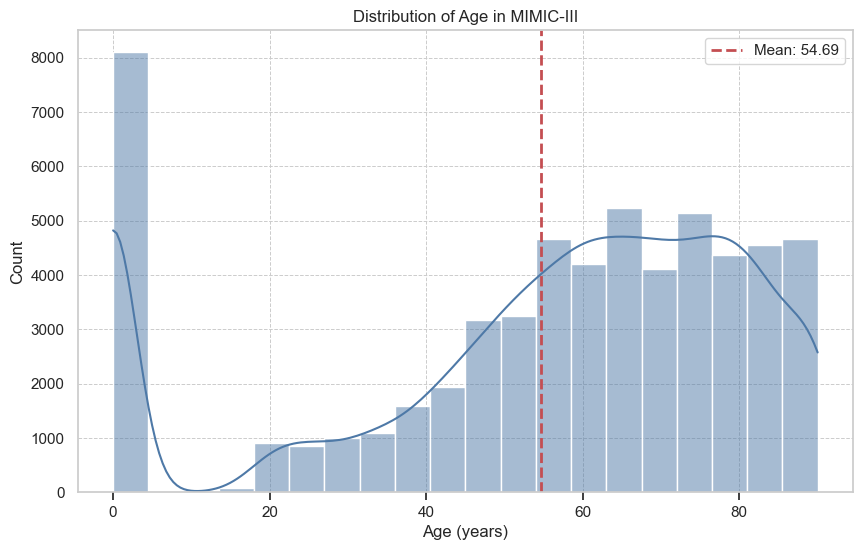

In [481]:
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=20, color='#4e79a7', kde=True)

# Add mean line
mean_age = df['age'].mean()
plt.axvline(mean_age, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_age:.2f}')

# Labels and title
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-III')

# Customize ticks and grid
plt.tick_params(left=False, bottom=True)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Add legend
plt.legend()

# Show the plot
plt.show()

In [482]:
age_buckets = [(0, 1), (1, 10), (10,20),(20, 36), (36, 55), (55, 100)]
for n, r in enumerate(age_buckets):
    df['age'] = np.where(df['age'].between(r[0],r[1]), 
            n, df['age'])
    
age_dict = {0: 'newborn', 1: 'young', 2: 'teenage', 3: 'middle_age', 4: 'senior', 5: 'old'}
df['age'] = df['age'].replace(age_dict)
df.age.value_counts()

age
old           35119
senior        11525
newborn        8101
middle_age     3569
teenage         564
Name: count, dtype: int64

C:\Users\debop\AppData\Local\Temp\ipykernel_16648\1905901487.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='age', y='LOS', data=df, palette='viridis')


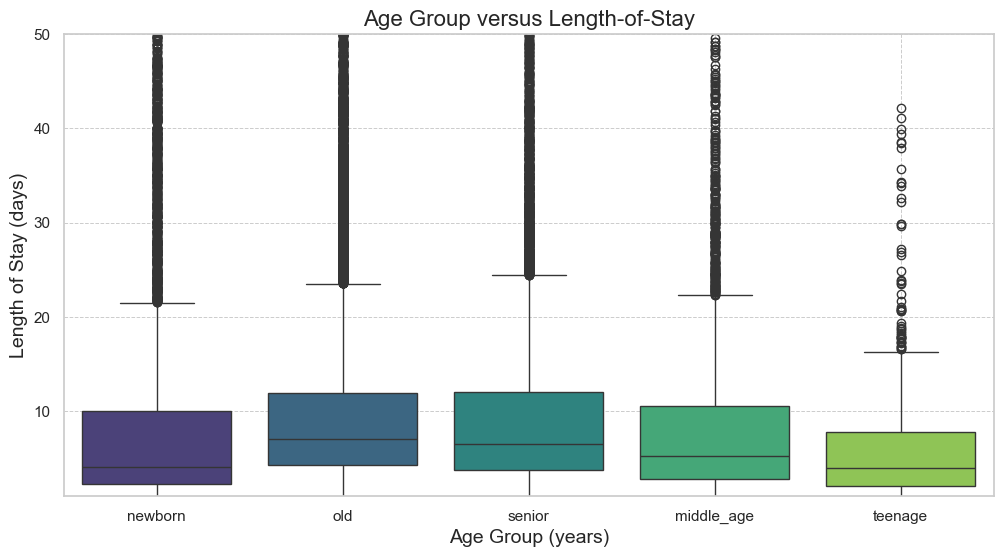

In [483]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='age', y='LOS', data=df, palette='viridis')

plt.ylabel('Length of Stay (days)', fontsize=14)
plt.xlabel('Age Group (years)', fontsize=14)
plt.title('Age Group versus Length-of-Stay', fontsize=16)

plt.ylim(1, 50)

plt.tick_params(top=False, right=False)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

plt.show()

In [484]:
df['GENDER'] = df['GENDER'].map({'M': 0, 'F': 1})

In [485]:
df['RELIGION'].loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE','OTHER'])] = 'RELIGIOUS'

C:\Users\debop\AppData\Local\Temp\ipykernel_16648\2928217470.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['RELIGION'].loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE','OTHER'])] = 'RELIGIOUS'
C:\Users\debop\AppData\Local\T

In [486]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58878 entries, 0 to 58877
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ROW_ID                58878 non-null  int64         
 1   SUBJECT_ID            58878 non-null  int64         
 2   HADM_ID               58878 non-null  int64         
 3   ADMITTIME             58878 non-null  datetime64[ns]
 4   DISCHTIME             58878 non-null  datetime64[ns]
 5   DEATHTIME             5774 non-null   object        
 6   ADMISSION_TYPE        58878 non-null  object        
 7   ADMISSION_LOCATION    58878 non-null  object        
 8   DISCHARGE_LOCATION    58878 non-null  object        
 9   INSURANCE             58878 non-null  object        
 10  LANGUAGE              33606 non-null  object        
 11  RELIGION              58878 non-null  object        
 12  MARITAL_STATUS        58878 non-null  object        
 13  ETHNICITY       

In [487]:
df.drop(columns=['ROW_ID','SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_LOCATION',
                'DISCHARGE_LOCATION', 'LANGUAGE', 'ADMITTIME_MIN', 'DOB',
                'DIAGNOSIS', 'DEATHTIME','ADMITTIME_MIN_YEAR','DOB_YEAR','EDREGTIME','DISCHTIME','EDOUTTIME','HOSPITAL_EXPIRE_FLAG','HAS_CHARTEVENTS_DATA'], inplace=True)

In [488]:
prefix_cols = ['ADMISSION', 'INSURANCE', 'RELIGION', 'ETHNICITY', 'AGE', 'MARRIED',]
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
             'ETHNICITY', 'age', 'MARITAL_STATUS']
df = pd.get_dummies(df, prefix=prefix_cols, columns=dummy_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58878 entries, 0 to 58877
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   LOS                               58878 non-null  float64
 1   blood                             58878 non-null  int64  
 2   circulatory                       58878 non-null  int64  
 3   congenital                        58878 non-null  int64  
 4   digestive                         58878 non-null  int64  
 5   endocrine                         58878 non-null  int64  
 6   genitourinary                     58878 non-null  int64  
 7   infectious                        58878 non-null  int64  
 8   injury                            58878 non-null  int64  
 9   mental                            58878 non-null  int64  
 10  misc                              58878 non-null  int64  
 11  muscular                          58878 non-null  int64  
 12  neop

In [490]:
label = df['LOS'].values
features = df.drop(columns=['LOS'])

In [491]:
X_train, X_test, y_train, y_test = train_test_split(features,label,test_size = .20,random_state = 42)

print(f"Training: {X_train.shape[0]} samples.")
print(f"Test: {X_test.shape[0]} samples.")

Training: 47102 samples.
Test: 11776 samples.


In [492]:
models = [
    SGDRegressor(random_state=42), 
    GradientBoostingRegressor(random_state=42), 
    LinearRegression(),
    KNeighborsRegressor(),
    RandomForestRegressor(random_state=42),
    Ridge(),
    XGBRegressor(random_state=42),
    SVR()
]

results = {}

for model in models:

    model.fit(X_train, y_train)

    y_test_preds = model.predict(X_test)
    
    name = model.__class__.__name__

    r2 = r2_score(y_test, y_test_preds)

    rmse = np.sqrt(mean_squared_error(y_test, y_test_preds))

    results[name] = {'R-squared': r2, 'RMSE': rmse}
    
    print(f'{name} ---> R-squared: {r2:.4f}, RMSE: {rmse:.4f}')

results_df = pd.DataFrame(results).T
print(results_df)

SGDRegressor ---> R-squared: 0.3091, RMSE: 10.5210
GradientBoostingRegressor ---> R-squared: 0.3960, RMSE: 9.8367
LinearRegression ---> R-squared: 0.3137, RMSE: 10.4862
KNeighborsRegressor ---> R-squared: 0.2848, RMSE: 10.7043
RandomForestRegressor ---> R-squared: 0.3715, RMSE: 10.0346
Ridge ---> R-squared: 0.3136, RMSE: 10.4864
XGBRegressor ---> R-squared: 0.3785, RMSE: 9.9789
SVR ---> R-squared: 0.2922, RMSE: 10.6486
                           R-squared       RMSE
SGDRegressor                0.309079  10.521022
GradientBoostingRegressor   0.396032   9.836732
LinearRegression            0.313650  10.486163
KNeighborsRegressor         0.284795  10.704321
RandomForestRegressor       0.371485  10.034634
Ridge                       0.313619  10.486399
XGBRegressor                0.378453   9.978855
SVR                         0.292227  10.648563


In [493]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [494]:
param_dist = {
    'n_estimators': sp_randint(100, 500),
    'max_depth': sp_randint(3, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, 
                                   n_iter=100, cv=kf, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

best_xgb_model = random_search.best_estimator_

print(f"Best Score: {random_search.best_score_}")
print(f"Best Estimator: {random_search.best_estimator_}")

y_test_preds = best_xgb_model.predict(X_test)

r2 = r2_score(y_test, y_test_preds)
rmse = np.sqrt(mean_squared_error(y_test, y_test_preds))

print(f'R-squared: {r2:.4f}, RMSE: {rmse:.4f}')

Best Score: 0.4018689715593665
Best Estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=437, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
R-squared: 0.4112, RMSE: 9.7122


In [495]:
feature_imp = pd.DataFrame(best_xgb_model.feature_importances_,index = X_train.columns,columns=['importance']).sort_values('importance', ascending=False)

feature_imp.head(20)

,importance
AGE_newborn,0.267446
prenatal,0.080589
ADMISSION_NEWBORN,0.045676
count_diagnoses,0.042188
respiratory,0.036800
infectious,0.034997
nervous,0.033392
ADMISSION_EMERGENCY,0.023536
ADMISSION_ELECTIVE,0.019870
MARRIED_UNKNOWN (DEFAULT),0.018675


In [496]:
np.random.seed(42)

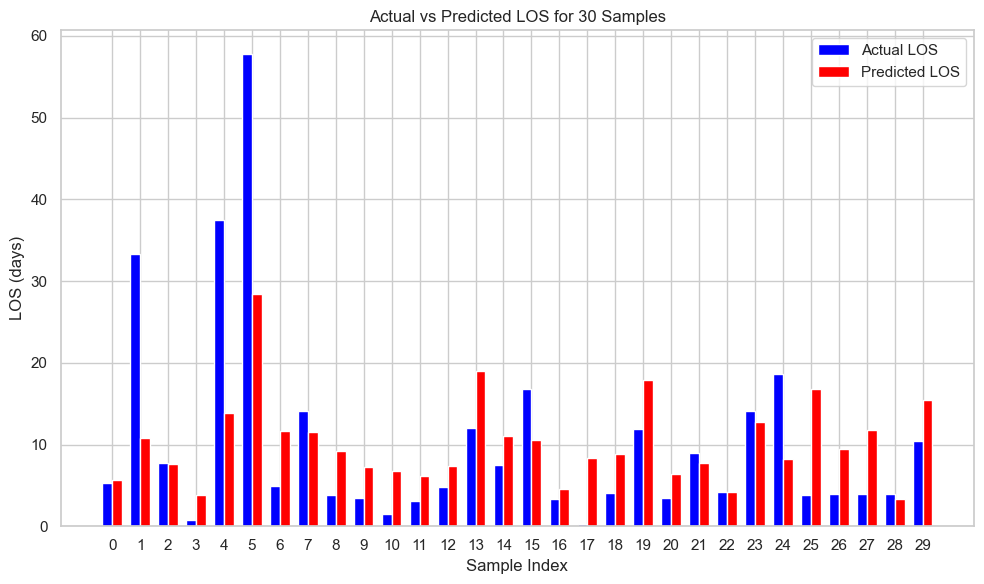

In [497]:
random_indices = np.random.choice(len(y_test), 30, replace=False)

y_test_30 = y_test[random_indices]
y_test_preds_30 = y_test_preds[random_indices]

# Generate indices for the bars
indices = np.arange(len(y_test_30))

# Set the width of the bars
bar_width = 0.35

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the actual LOS
ax.bar(indices, y_test_30, bar_width, color='blue', label='Actual LOS')

# Plot the predicted LOS
ax.bar(indices + bar_width, y_test_preds_30, bar_width, color='red', label='Predicted LOS')

# Add labels, title, and legend
ax.set_xlabel('Sample Index')
ax.set_ylabel('LOS (days)')
ax.set_title('Actual vs Predicted LOS for 30 Samples')
ax.set_xticks(indices + bar_width / 2)
ax.set_xticklabels(indices)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


In [498]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': sp_randint(100, 500),
    'max_depth': sp_randint(3, 10),
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(1, 20),
    'max_features': ['sqrt', 'log2']
}

# Create the GradientBoostingRegressor model
gb_model = GradientBoostingRegressor(random_state=42)

# Create the RandomizedSearchCV object
random_search_gb = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist, 
                                      n_iter=100, cv=kf, random_state=42, n_jobs=-1)

# Fit the model
random_search_gb.fit(X_train, y_train)

# Get the best model from the randomized search
best_gb_model = random_search_gb.best_estimator_

# Print the best score and best estimator
print(f"Best Score: {random_search_gb.best_score_}")
print(f"Best Estimator: {random_search_gb.best_estimator_}")

# Predict on the test set
y_test_preds_gb = best_gb_model.predict(X_test)

# Calculate R-squared and RMSE
r2_gb = r2_score(y_test, y_test_preds_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_test_preds_gb))

print(f'R-squared: {r2_gb:.4f}, RMSE: {rmse_gb:.4f}')

Best Score: 0.40551008844634717
Best Estimator: GradientBoostingRegressor(learning_rate=0.05, max_depth=7, max_features='sqrt',
                          min_samples_leaf=4, min_samples_split=4,
                          n_estimators=246, random_state=42)
R-squared: 0.4183, RMSE: 9.6534


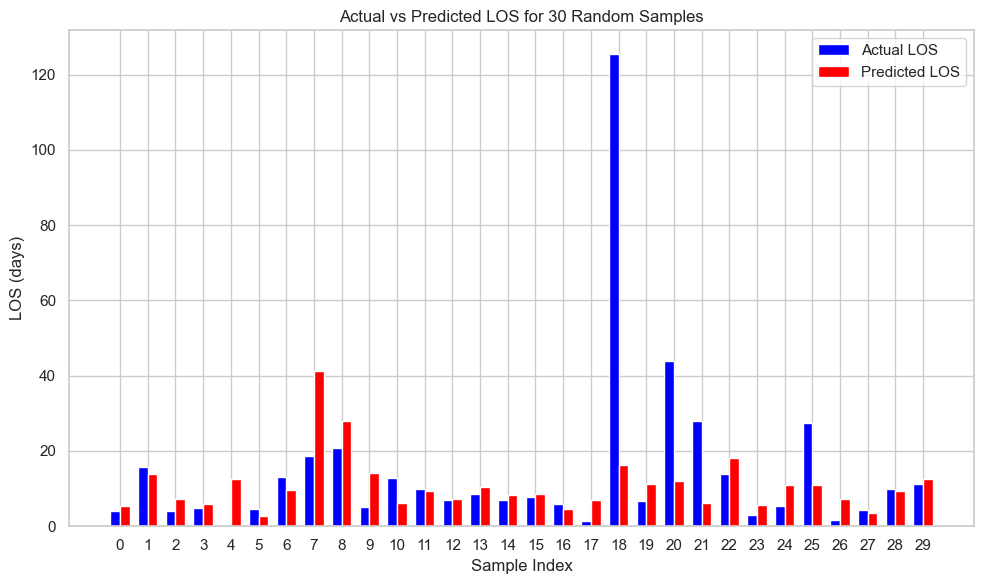

In [499]:
random_indices = np.random.choice(len(y_test), 30, replace=False)

y_test_30 = y_test[random_indices]
y_test_preds_30 = y_test_preds_gb[random_indices]

indices = np.arange(len(y_test_30))

bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(indices, y_test_30, bar_width, color='blue', label='Actual LOS')

ax.bar(indices + bar_width, y_test_preds_30, bar_width, color='red', label='Predicted LOS')

ax.set_xlabel('Sample Index')
ax.set_ylabel('LOS (days)')
ax.set_title('Actual vs Predicted LOS for 30 Random Samples')
ax.set_xticks(indices + bar_width / 2)
ax.set_xticklabels(indices)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

In [500]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Convert DataFrame and target array to NumPy arrays
X_numpy = features.to_numpy()
y_numpy = label

# Convert NumPy arrays to TensorFlow tensors
X = tf.convert_to_tensor(X_numpy, dtype=tf.float32)
y = tf.convert_to_tensor(y_numpy, dtype=tf.float32)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.2, random_state=42)

# Convert the split data back to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

input_shape = X_train.shape[1] 
# Build the model
model = Sequential([
    Input(shape=(input_shape,)),  # Input layer with specified shape
    Dense(64, activation='relu'),  # Hidden layer with 64 units
    Dense(32, activation='relu'),  # Hidden layer with 32 units
    Dense(1)  # Output layer with 1 unit
])
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Predict on the test set
y_test_preds = model.predict(X_test)

# Calculate R-squared and RMSE
r2 = r2_score(y_test, y_test_preds)
rmse = np.sqrt(mean_squared_error(y_test, y_test_preds))

print(f'R-squared: {r2:.4f}, RMSE: {rmse:.4f}')

Epoch 1/10
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 127.0591 - val_loss: 102.9606
Epoch 2/10
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 99.0149 - val_loss: 101.1601
Epoch 3/10
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 99.4327 - val_loss: 99.1392
Epoch 4/10
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 92.7394 - val_loss: 99.2267
Epoch 5/10
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 93.1975 - val_loss: 99.0833
Epoch 6/10
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 91.7673 - val_loss: 98.9645
Epoch 7/10
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 91.2331 - val_loss: 97.3863
Epoch 8/10
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 96.3723 - val_loss: 99.1274
Epoch 9/10
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 93.2608 - val_loss: 96.8424
Epoch 10/10
1472/1472 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 93.4964 - val_loss: 97.6989
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 113.5703
Test Loss: 97.69886016845703
368/368 ━